# **Setup**


In [1]:
!pip install pydicom

In [2]:
import pydicom as pdm
import skimage as sk
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import cv2

from skimage.transform import resize
from skimage.io import imread
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')
# drive.flush_and_unmount()
os.chdir("/content/gdrive/My Drive/Colab Notebooks/data")
os.getcwd()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


'/content/gdrive/My Drive/Colab Notebooks/data'

# **Part 1: Working with image files**
*   Load DICOM or PNG file.
*   Resize the image to user-specified dimensions (e.g. 229 x 229).
*   Write the resized image to numpy .npy files.
*   Combine the .npy files with breast density information. Store this into numpyz .npz files.



In [4]:
def resize_image(filepath, custom_shape, verbose=False):
  assert os.path.exists(filepath), "ERROR: file " + filepath + " not found!"

  if filepath.endswith(".png"):
    png_ndarray = imread(filepath)
    print_msg("Resizing PNG file...", verbose)
    png_resized = resize(image=png_ndarray, output_shape=custom_shape, anti_aliasing=False)
    print_msg("Success.", verbose)
    return (png_ndarray, png_resized)

  else:
    print_msg("Reading DICOM file...", verbose)
    dicom_dataset = pdm.dcmread(fp=filepath, defer_size=None, force=True)
    if not filepath.endswith("dcm"):
      print_msg("Decompressing DICOM file...", verbose)
      dicom_dataset = dicom_dataset.decompress()
    dicom_ndarray = dicom_dataset.pixel_array
    print_msg("Success.", verbose)

    print_msg("Resizing DICOM file...", verbose)
    dicom_resized = resize(image=dicom_ndarray, output_shape=custom_shape, anti_aliasing=False)
    print_msg("Success.", verbose) 

    return (dicom_dataset, dicom_resized)

In [19]:
def save_to_npy(save_to, arr_data, verbose=False):
  npy_path = save_to + ".npy"
  np.save(npy_path, arr_data)
  print_msg("Success.", verbose)

  return npy_path

In [21]:
def save_to_npz(save_to, read_from, breast_density, verbose=False):
  print_msg("Loading npy file " + read_from + "...", verbose)
  resized_arr = np.load(file=read_from, allow_pickle=False)
  num_rows, num_cols = resized_arr.shape
  print_msg("Success.", verbose)

  print_msg("Creating new data with breast_density ...", verbose)
  new_arr = np.zeros((num_rows + 1, num_cols))
  for i in range(num_rows):
    new_arr[i] = resized_arr[i,:]
  new_arr[num_rows] = np.full(shape=(num_cols,), fill_value=breast_density)
  print_msg("Success.", verbose)

  npz_path = save_to + ".npz"
  print_msg("Saving to npz file " + npz_path + "...", verbose)
  np.savez(npz_path, new_arr)
  print_msg("Success.", verbose)

  return npz_path

In [22]:
def get_patient_id(filepath):
  i = filepath.index("P_") + 2
  patient_id = "P_"
  while filepath[i].isnumeric():
    patient_id += filepath[i]
    i += 1
  print("patient id is " + patient_id)
  return patient_id

In [9]:
def get_breast_density(df, patient_id):
  breast_density = df.loc[patient_id, "breast_density"]
  if breast_density.size > 1:
    breast_density = breast_density[0]
  return breast_density

In [28]:
def get_image_files(dir_path):
  print("getting image files...")
  train_files = {}
  test_files = {}
  for root, dirs, files in os.walk(dir_path):
    if files and files[0].endswith(".dcm"):
      if "Training" in root:
        train_files[root] = files[0]
      elif "Testing" in root:
        test_files[root] = files[0]
  print("done getting image files!")
  return (train_files, test_files)

In [11]:
def get_scan_type(filepath):
  scan_type = "LEFT_" if "LEFT_" in filepath else "RIGHT_"
  scan_type += "CC" if "CC" in filepath else "MLO"
  return scan_type

In [12]:
def print_msg(msg, verbose):
  if verbose:
    print(msg)

In [13]:
def sort_npy_npz_files(dir):
  npy_dir = os.path.join(dir, "npy files")
  if not os.path.exists(npy_dir):
    os.mkdir(npy_dir)
  npz_dir = os.path.join(dir, "npz files")
  if not os.path.exists(npz_dir):
    os.mkdir(npz_dir)
  for f in os.listdir(dir):
    if f.endswith(".npy"):
      os.rename(os.path.join(dir, f), os.path.join(dir, npy_dir, f))
    elif f.endswith(".npz"):
      os.rename(os.path.join(dir, f), os.path.join(dir, npz_dir, f))

In [29]:
def main_helper(files_dict, df, resize_shape=(229, 229), save=True, verbose=False):
  
  data = []
  labels = []
  # resize_dir = os.path.join(os.getcwd(), "resized images")

  for fpath in files_dict:
    patient_id = get_patient_id(fpath)
    scan_type = get_scan_type(fpath)
    breast_density = get_breast_density(df, patient_id)
    image_fp = files_dict[fpath]

    dataset, resized_ndarray = resize_image(filepath=os.path.join(fpath, image_fp), custom_shape=resize_shape, verbose=verbose)
    # if save:
    #   if not os.path.exists(resize_dir):
    #     os.mkdir(resize_dir)
    #   output_path = os.path.join(resize_dir, patient_id + "_" + scan_type + "_" + image_fp)
    #   print_msg("Saving resized image to " + output_path, verbose)
    #   if image_fp.endswith("PNG"):
    #     plt.imsave(output_path, resized_ndarray)
    #   else:
    #     # new_ds = pdm.dataset.Dataset(dataset)
    #     dataset.save_as(output_path)
    #   print_msg("Success.", verbose)
    np_path = os.path.join(os.getcwd(), patient_id + "_" + scan_type)
    npy_path = save_to_npy(save_to=np_path, arr_data=resized_ndarray, verbose=verbose)
    npz_path = save_to_npz(save_to=np_path, read_from=npy_path, breast_density=breast_density)
    sort_npy_npz_files(os.getcwd())

    data.append(resized_ndarray)
    labels.append(0 if breast_density <= 2 else 1) # not dense for 1, 2 ; dense for 3, 4

  return (data, labels)

In [24]:
def main(dir_path, resize_shape=(229, 229), save=True, verbose=False):
  train_csv = os.path.join(os.getcwd(), "mass_case_description_train_set.csv")
  test_csv = os.path.join(os.getcwd(), "mass_case_description_test_set.csv")
  train_df = pd.read_csv(train_csv, index_col="patient_id")
  test_df = pd.read_csv(test_csv, index_col="patient_id")

  train_files, test_files = get_image_files(dir_path)

  train_data, train_labels = main_helper(train_files, train_df, resize_shape, save, verbose)
  test_data, test_labels = main_helper(test_files, test_df, resize_shape, save, verbose)
  return (train_data, train_labels, test_data, test_labels)

# **Testing**

In [30]:
# pdm.config.debug()
dir_path = os.getcwd()
train_data, train_labels, test_data, test_labels = main(dir_path, verbose=True)

getting image files...
done getting image files!
patient id is P_00059
Reading DICOM file...
Success.
Resizing DICOM file...
Success.
Success.
patient id is P_00034
Reading DICOM file...
Success.
Resizing DICOM file...
Success.
Success.
patient id is P_00298
Reading DICOM file...
Success.
Resizing DICOM file...
Success.
Success.
patient id is P_00172
Reading DICOM file...
Success.
Resizing DICOM file...
Success.
Success.
patient id is P_00303
Reading DICOM file...
Success.
Resizing DICOM file...
Success.
Success.
patient id is P_00018
Reading DICOM file...
Success.
Resizing DICOM file...
Success.
Success.
patient id is P_00240
Reading DICOM file...
Success.
Resizing DICOM file...
Success.
Success.
patient id is P_00110
Reading DICOM file...
Success.
Resizing DICOM file...
Success.
Success.
patient id is P_00239
Reading DICOM file...
Success.
Resizing DICOM file...
Success.
Success.
patient id is P_00057
Reading DICOM file...
Success.
Resizing DICOM file...
Success.
Success.
patient id 

# **Part 2: Machine Learning**

In [65]:
train_data = np.asarray(train_data)
train_data.shape # (250, 299, 299)
train_data = tf.convert_to_tensor(train_data)
print(train_data)

train_labels = np.asarray(train_labels)
train_labels.shape # (250,)

# test_data = np.asarray(test_data)
# test_data.shape # (250, 299, 299)

# test_labels = np.asarray(test_labels)
# test_labels.shape # (250,)

tf.Tensor(
[[[1.         1.         1.         ... 0.         0.         0.        ]
  [1.         1.         1.         ... 0.         0.         0.        ]
  [1.         1.         1.         ... 0.         0.         0.        ]
  ...
  [1.         1.         1.         ... 0.         0.         0.        ]
  [1.         1.         1.         ... 0.         0.         0.        ]
  [1.         1.         1.         ... 0.         0.         0.        ]]

 [[1.         1.         1.         ... 0.23858315 0.2369332  0.23594304]
  [1.         1.         1.         ... 0.         0.         0.        ]
  [1.         1.         1.         ... 0.         0.         0.        ]
  ...
  [1.         1.         1.         ... 1.         1.         1.        ]
  [1.         1.         1.         ... 1.         1.         1.        ]
  [1.         1.         1.         ... 1.         1.         1.        ]]

 [[0.92746696 0.85934125 0.85992264 ... 0.0865304  0.59317581 0.74289591]
  [0.928178

(250,)

In [66]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
# train_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_labels))

In [67]:
batch_size = 5
shuffle_buffer_size = 50

train_dataset = train_dataset.shuffle(shuffle_buffer_size).batch(batch_size)
# test_dataset = test_dataset.batch(batch_size)
for element in train_dataset.as_numpy_iterator():
  print(element)

(array([[[8.62221836e-01, 8.79789146e-01, 8.06684268e-01, ...,
         6.58916009e-02, 8.04259926e-02, 1.04254464e-01],
        [8.69768493e-01, 8.10956710e-01, 7.77276533e-01, ...,
         6.05129643e-02, 6.98428544e-02, 7.99617539e-02],
        [8.73924549e-01, 8.09533748e-01, 7.85749136e-01, ...,
         5.15099896e-02, 6.18485690e-02, 7.87839925e-02],
        ...,
        [8.95786039e-01, 2.26283000e-01, 1.57844258e-01, ...,
         8.91636180e-03, 1.41240810e-03, 5.70889217e-03],
        [8.81945782e-01, 1.97727957e-01, 1.51357969e-01, ...,
         2.13521666e-02, 2.24453723e-02, 3.30812422e-02],
        [7.99797233e-01, 2.32510407e-01, 1.69378110e-01, ...,
         4.34119754e-02, 5.59970881e-02, 6.10290594e-02]],

       [[6.61644721e-01, 6.44460730e-01, 4.85746213e-01, ...,
         7.99420164e-01, 7.99362303e-01, 8.70789309e-01],
        [6.52497275e-02, 6.51133768e-02, 7.01370779e-02, ...,
         1.19876258e-01, 1.26777818e-01, 1.52045764e-01],
        [2.71280850e-03,

Epoch 1/10

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

50/50 [==============================] - 1s 27ms/step - loss: 0.6609 - sparse_categorical_accuracy: 0.6400
Epoch 2/10
50/50 [==============================] - 1s 27ms/step - loss: 0.6491 - sparse_categorical_accuracy: 0.6600
Epoch 3/10
50/50 [==============================] - 1s 27ms/step - loss: 0.6503 - sparse_categorical_accuracy: 0.6600
Epoch 4/10
50/50 [==============================] - 1s 27ms/step - loss: 0.6555 - sparse_categorical_accuracy: 0.6600
Epoch 5/10
50/50 [==================

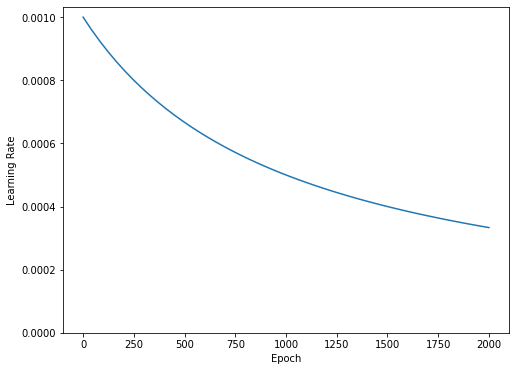

In [96]:
steps_per_epoch = 250/batch_size

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
                    0.001,
                    decay_steps=steps_per_epoch*1000,
                    decay_rate=1,
                    staircase=False)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

step = np.linspace(0,100000)
lr = lr_schedule(step)
plt.figure(figsize = (8,6))
plt.plot(step/steps_per_epoch, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')

model = tf.keras.Sequential([
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(64, activation='tanh'),
            tf.keras.layers.Dense(32, activation='sigmoid'),
            tf.keras.layers.Dense(2)
])

model.compile(optimizer=get_optimizer(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['sparse_categorical_accuracy'])

model.fit(train_dataset, epochs=10)


# **Documentation**

**`resize_image(filepath, custom_shape, show=True, verbose=False)`**
*   Inputs 
  * FILEPATH: string path of image file to resize
  * CUSTOM_SHAPE: tuple of resized dimensions (e.g. (299, 299))
  * [SHOW=True]: plot image before and after resizing
  * [VERBOSE=False]: do not print intermediate progress
*   Outputs
  1. if DICOM, dataframe; if PNG, original image numpy array
  2. resized array
*  Functionality
  * Resizes input image file to custom dimension and returns the original dataframe or image array and the resized array. 


**`save_to_npy(filepath, arr_data, verbose=False)`**
*   Inputs
  * FILEPATH: desired numpy filepath string (no extensions)
  * ARR_DATA: numpy array to save in the numpy file
  * [VERBOSE=False]: do not print intermediate progress
*   Outputs
  1. NPY_PATH: the full numpy filepath (with .npy extension)
*   Functionality
  * Saves input data to a numpy file using the desired filepath.


**`save_to_npz(save_to, read_from, breast_density, verbose=False)`**
*   Inputs
  * SAVE_TO: desired numpyz filepath string (no extensions)
  * READ_FROM: numpy filepath containing the resized image ndarray
  * BREAST_DENSITY: integer
  * [VERBOSE=False]: do not print intermediate progress
*   Outputs
    1. NPZ_PATH: the full numpyz path (with .npz extension)
*   Functionality
  * Saves input array and breast density to a new numpyz file.

**`get_breast_density(df, patient_id)`**
*  Inputs
  * DF: dataframe from reading csv file (for breast density info)
  * PATIENT_ID: patient id (attribute of dataset from reading DICOM file)
*  Outputs
    1. breast density (integer) of input patient
*  Functionality
  * Returns the breast density corresponding to PATIENT_ID


**`main`**
*  Inputs
  * DIR: directory of image files to operate on
  * [RESIZE_SHAPE=(229, 229)]: tuple of desired resizing dimensions
  * [VERBOSE=False]: do not print intermediate progress
*  Outputs
  * 1. python array of training image pixel arrays
  * 2. python array of training labels (*i*th label corresponds to the *i*th training image pixel array)
  * 3. python array of testing image pixel arrays
  * 4. python array of testing labels (*i*th label corresponds to the *i*th training image pixel array)
*  Functionality
  * For each DICOM file in DIR,
    1. resize
    2. save to numpy file
    3. save to numpyz file with breast density information